#**Trabalho 2** - Visão Computacional 2022/1


Segundo trabalho para disciplina de Visão Computacional

Profa. Dra. Raquel Frizera Vassallo

Universidade Federal do Espírito Santo - UFES.

Bruno Baptista Guerra

Thalis Pestana Rocha

02/07/2022

Para realização dos testes feitos, lembre de importar as imagens que foram disponibilizadas no arquivo .zip do Materia 05 encontrado no *Google Classroom*.

Primeirio, vamos instalar uma versão específica do OpenCV para usar a função de homografia, assim como o detector SIFT e algumas funções correspondentes que estão disponíveis nas bibliotecas do OpenCV.

In [ ]:
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.5 MB 85 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55.7 MB 1.2 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


## Libraries

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Functions

As funções a seguir seguem a base do arquivo enviado pela professora como forma de estruturar o projeto a ser apresentado.

In [ ]:
# Função para normalizar pontos
# Entrada: points (pontos da imagem a serem normalizados)
# Saída: T (matriz de normalização)
def normalize_points(points):
  #Definir pontos x e y
  x = points[0]
  y = points[1]

  # Centroide em x e em y
  c_x = np.sum(x)/len(x)
  c_y = np.sum(y)/len(y)

  soma_dist = np.sum( np.sqrt((x - c_x)**2 + (y - c_y)**2) )
  s = ( np.sqrt(2)*len(x) ) / ( soma_dist )

  T = np.array([[1, 0, -c_x],
                [0, 1, -c_y],
                [0, 0,  1/s]])
  T = T*s
     
  return T


# Função montar a matriz A e aplicar o DLT Normalizado
# Entrada: pts1, pts2 (pontos "pts1" da primeira imagem e pontos "pts2" da segunda imagem que atendem a pts2=H.pts1)
# Saída: H (matriz de homografia estimada)
def compute_normalized_dlt(pts1, pts2):

  # Normaliza pontos
  T1 = normalize_points(pts1)
  p_1 = np.dot(T1, pts1)

  T2 = normalize_points(pts2)
  p_2 = np.dot(T2, pts2)

  # Constrói o sistema de equações empilhando a matrix A de cada par de pontos correspondentes normalizados
  A = []
  for idx in range(p_1.shape[1]):
    x2 = p_2[0, idx]
    y2 = p_2[1, idx]
    w2 = p_2[2, idx]

    A1 =   0 * p_1[:, idx]
    A2 = -w2 * p_1[:, idx]
    A3 =  y2 * p_1[:, idx]
    A4 =  w2 * p_1[:, idx]
    A5 =   0 * p_1[:, idx]
    A6 = -x2 * p_1[:, idx]
    
    A.append(np.concatenate((A1, A2, A3, A4, A5, A6)))
  
  #A (matriz com as duas ou três linhas resultantes da relação pts2 x H.pts1 = 0)
  A = np.array(A)
  A = A.reshape((2*len(pts1[0]), 9))

  if np.any(np.isnan(A)) or np.any(np.isinf(A)):
    A = np.nan_to_num(A)

  # Calcula o SVD da matriz A_empilhada e estima a homografia H_normalizada 
  U, S, V = np.linalg.svd(A)
  h = V[8,:].reshape((3,3))

  # Denormaliza H_normalizada e obtém H
  H = np.dot(np.linalg.inv(T2), np.dot(h, T1))
  H = H/H[-1,-1]

  return H

# Função do RANSAC
# Entradas: pts1: pontos da primeira imagem
#           pts2: pontos da segunda imagem 
#           config: [samples, p, e, T]
# Saídas: H: homografia estimada
#         pts1_in, pts2_in: conjunto de inliers dos pontos da primeira e segunda imagens
def RANSAC(pts1, pts2, config):
  # Define outros parâmetros como número de amostras do modelo, probabilidades da equação de N, etc 
  n_pts = pts1.shape[1]  # Número de pontos
  samples = config[0]    # Número de amostras
  best_H = np.eye(3)

  # Processo Iterativo
  # Enquanto não atende a critério de parada
  if n_pts > samples:
    p = config[1]   # Prob. da sample não ter outliers
    e = config[2]   # Proporção de outliers
    T = config[3]   # Threshold

    N = np.log10(1-p) / np.log10(1-(1-e)**samples) # Número máximo de amostras
    num_inlier = 0
    num_max_inlier = 0
    idx = 0 # Seleções

    while N > idx:
      idx += 1
   
      # Sorteia aleatoriamente "samples" amostras do conjunto de pares de pontos pts1 e pts2 
      seed_samples = np.random.choice(range(n_pts), size = samples)
      pts1_sample = np.vstack((
          np.take(pts1[0], seed_samples),
          np.take(pts1[1], seed_samples),
          np.take(pts1[2], seed_samples)
      ))
      pts2_sample = np.vstack((
          np.take(pts2[0], seed_samples),
          np.take(pts2[1], seed_samples),
          np.take(pts2[2], seed_samples)
      ))  
    
    # Usa as amostras para estimar uma homografia usando o DTL Normalizado
    H_temp = compute_normalized_dlt(pts1_sample, pts2_sample)

    # Testa essa homografia com os demais pares de pontos usando o dis_threshold e contabiliza
    pts_estimated_p2 = np.dot(H_temp, pts1)
    pts_estimated_p2 = pts_estimated_p2/pts_estimated_p2[2]
    error_p2 = np.sqrt((pts2[0] - pts_estimated_p2[0])**2 + (pts2[1] - pts_estimated_p2[1])**2)

    # o número de supostos inliers obtidos com o modelo estimado
    num_inlier = np.count_nonzero(error_p2 < T)

    # Se o número de inliers é o maior obtido até o momento, guarda esse conjunto além das "samples" amostras utilizadas. 
    if num_inlier > num_max_inlier:
      num_max_inlier = num_inlier
      coord_pts = np.nonzero(error_p2 < T) 
      mask = np.where(error_p2 < T, 1, 0)
      best_H = H_temp
      # Atualiza também o número N de iterações necessárias
    else:
      e = 1 - num_inlier/n_pts
      N = np.log10(1-p) / np.log10(1-(1-e)**samples)

  # Terminado o processo iterativo
  else:
    coord_pts = np.arange(samples)
    mask = np.ones(samples)
  
  # Estima a homografia final H usando todos os inliers selecionados.
  mask = mask.reshape((len(mask), 1))

  return coord_pts, mask, best_H

### Função para encontrar a homografia

In [ ]:
def separate_points(pts, coord):
  pts = np.vstack((np.take(pts[0], coord),
                   np.take(pts[1], coord),
                   np.take(pts[2], coord)))
  return pts

In [ ]:
# Função de encontrar Homografia
# Entradas: pts_origin: pontos da primeira imagem
#           pts_destin: pontos da segunda imagem 
#           config: [samples, p, e, T]
# Saídas: H: homografia estimada
#         mask: conjunto de inliers dos pontos da primeira e segunda imagens

def my_find_Homography(pts_origin, pts_destin, config = [4, 0.99, 0.50, 1]):
  # Mudamos o sistema de coordenadas
  if len(pts_origin.shape) > 2:
    pts_origin = np.reshape(pts_origin,(pts_origin.shape[0],2))
    pts_destin = np.reshape(pts_destin,(pts_destin.shape[0],2))

  pts1_o = np.insert(pts_origin, 2, 1, axis=1).T
  pts2_o = np.insert(pts_destin, 2, 1, axis=1).T

  # RANSAC
  coord_inliers, mask, H_ran = RANSAC(pts1_o, pts2_o, config)

  # Separamos apenas os inliers do conjunto de pontos
  pts1 = separate_points(pts1_o, coord_inliers)
  pts2 = separate_points(pts2_o, coord_inliers)

  # Aplicamos o DTL com normalização imbutida para os inliers encontrados
  H = compute_normalized_dlt(pts1, pts2)

  # Caso a matriz H encontrada seja singular, refazemos o RANSAC para
  # selecionar um novo conjunto de pontos e recalcular H
  while np.linalg.det(H) == 0:
    coord_inliers, mask, H_ran = RANSAC(pts1_o, pts2_o, config)
    pts1 = separate_points(pts1_o, coord_inliers)
    pts2 = separate_points(pts2_o, coord_inliers)
    H = compute_normalized_dlt(pts1, pts2)

  # Retornamos a matriz de transformação
  return H, mask

# Testando as Funções

Nesse primeiro teste, aplicamos a função 'my_find_homography' para encontrar a homografia com os pontos já definidos na imagem e comparamos com o matriz H encontrada pelo OpenCV, felizmente podemos observar que os valores da matriz são idêticos.

---

Utilizamos como base o exemplo "sift_homography.ipynb" com  mostrado em sala e disponibilizado no *Google Classroom*.

In [ ]:
img1 = cv.imread('comicsStarWars02.jpg', 0)
corners_img1 = np.array([[105,123],[650,55],[580,1055],[58,920]])
corners_img2 = np.array([[58,123],[650,123],[650,1000],[58,1000]])

src_pts = np.float32(corners_img1)
dst_pts = np.float32(corners_img2)

#Função do OpenCV
M_cv, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

#Minha função
M_my, _ = my_find_Homography(src_pts, dst_pts)

# Aplicando a transformação na imagem
img2 = cv.warpPerspective(img1, M_cv, (img1.shape[1],img1.shape[0]))
img3 = cv.warpPerspective(img1, M_my, (img1.shape[1],img1.shape[0]))

print('\nMatriz H do OpenCV: \n', M_cv)
print('Matriz H da minha função: \n', M_my)


Matriz H do OpenCV: 
 [[ 1.47954030e+00  8.60027795e-02 -1.04827095e+02]
 [ 2.04861192e-01  1.14982011e+00 -3.33578455e+01]
 [ 5.00162539e-04  7.98823695e-06  1.00000000e+00]]
Matriz H da minha função: 
 [[ 1.47954030e+00  8.60027795e-02 -1.04827095e+02]
 [ 2.04861192e-01  1.14982011e+00 -3.33578455e+01]
 [ 5.00162539e-04  7.98823695e-06  1.00000000e+00]]


#Usando SIFT para estimar a homografia entre imagens e deformar a primeira imagem

Nesse segundo teste, utilzamos novamente a nossa função e o SIFT para aplicar uma transformação de uma imagem em relação a outra.

---

Dentre todos os testes que foram executados, repetimos esse bloco de código no Colab até chegar em um valor de inliers da minha função que se aproxima-se do encontrado do OpenCV, logo, melhor resultado que encontramos foi:

N° pontos originais:  428

N° de inliers OpenCV:  281

N° de inliers  minha função:  119

In [ ]:
MIN_MATCH_COUNT = 10
img1 = cv.imread('minions02a.jpg',0) # queryImage
img2 = cv.imread('minions01a.jpg',0) # trainImage

# Inicialização do SIFT
sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)


# FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
for m,n in matches:
  if m.distance < 0.75 * n.distance:
    good.append(m)

if len(good)>MIN_MATCH_COUNT:
  src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

  #Função do OpenCV
  M_cv, mask_cv = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

  #Minha função
  M_my, mask_my = my_find_Homography(src_pts, dst_pts, [4, 0.99, 0.25, 5.0])

  h,w = img1.shape
  pts = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1,1,2)

  # Processo de desenhar linhas com a minha função
  matchesMask_my = mask_my.ravel().tolist()
  dst = cv.perspectiveTransform(pts, M_my)
  img4 = cv.polylines(img2, [np.int32(dst)], True, 255, 3, cv.LINE_AA)
  img3 = cv.warpPerspective(img1, M_my, (img2.shape[1],img2.shape[0]))

else:
  print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
  matchesMask = None

draw_params_my = dict(matchColor = (0,98,255), # draw matches in amarelo color
                   singlePointColor = None,
                   matchesMask = matchesMask_my, # draw only inliers
                   flags = 2)
img3_2 = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params_my)

print('N° pontos originais: ', len(src_pts))
print('N° de inliers OpenCV: ', np.count_nonzero(mask_cv))
print('N° de inliers  minha função: ', np.count_nonzero(mask_my))

print('\nMatriz H do OpenCV: \n', M_cv)
print('Matriz H da minha função: \n', M_my)

N° pontos originais:  469
N° de inliers OpenCV:  391
N° de inliers  minha função:  338

Matriz H do OpenCV: 
 [[ 7.94698022e-01  1.93080443e-02  1.60425046e+00]
 [-6.85146253e-02  8.20105487e-01  1.08545994e+02]
 [-1.58979453e-04  8.36799390e-06  1.00000000e+00]]
Matriz H da minha função: 
 [[ 7.99802972e-01  2.18004531e-02 -2.65740222e-01]
 [-6.65558414e-02  8.25829040e-01  1.06685052e+02]
 [-1.55360667e-04  1.14208609e-05  1.00000000e+00]]


<Figure size 432x288 with 0 Axes>

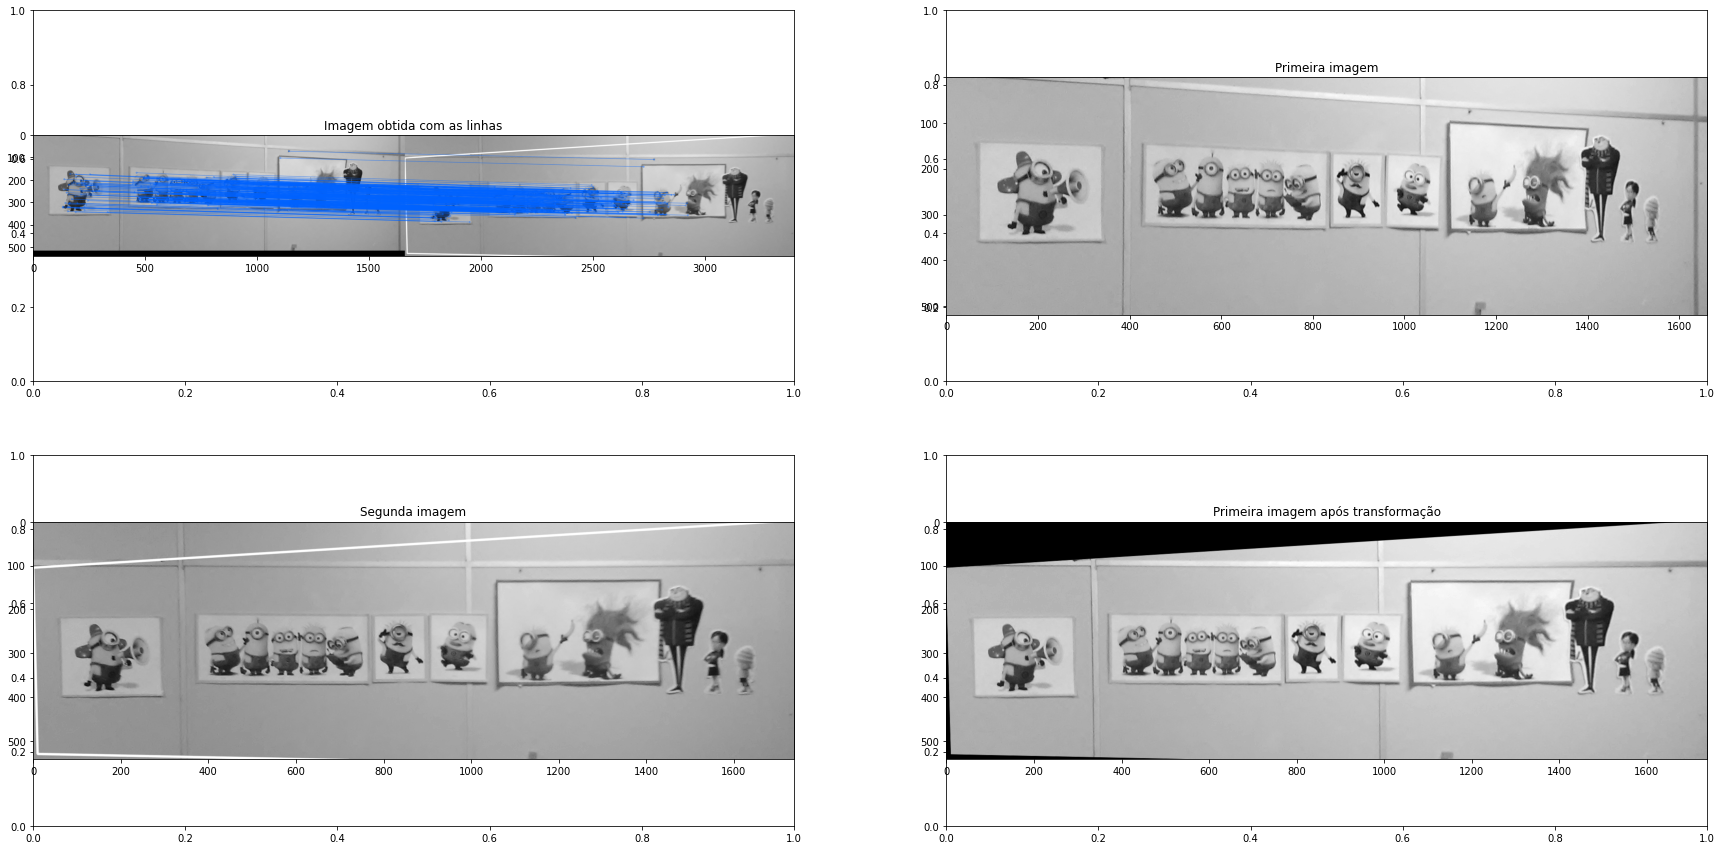

In [ ]:
fig = plt.figure()
fig, axs = plt.subplots(2,2,figsize=(30,15))
ax1 = fig.add_subplot(2,2,1)
plt.title('Imagem obtida com as linhas')
plt.imshow(img3_2, 'gray')
ax1 = fig.add_subplot(2,2,2)
plt.title('Primeira imagem')
plt.imshow(img1,'gray')
ax1 = fig.add_subplot(2,2,3)
plt.title('Segunda imagem')
plt.imshow(img2,'gray')
ax1 = fig.add_subplot(2,2,4)
plt.title('Primeira imagem após transformação')
plt.imshow(img3,'gray')
plt.show()